# Recommender System

In [1]:
## Basic
import pandas as pd
import numpy as np

In [2]:
## Recommender imports
# Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
## Utils
import os

# https://stackoverflow.com/questions/66920753/running-a-justpy-web-app-on-jupyter-returns-runtimeerror
import nest_asyncio
nest_asyncio.apply()

In [4]:
# Import functions
# https://stackoverflow.com/questions/20186344/ipynb-import-another-ipynb-file
%run MMDb_functions.ipynb

## Functions

In [5]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, indices, cosine_sim, N=10):
    # Get the index of the movie that matches the title
    idx = indices[title]    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    # Get the scores of the n most similar movies
    sim_scores = sim_scores[1:N]
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    # Select columns to show
    cols = ['title','year','genre','duration','country','director','writer','votes','avg_vote','metascore','description']
    recommend = df_clean[cols].iloc[movie_indices].copy()
    recommend['score'] = [i[1] for i in sim_scores]
    
    # Return the top N most similar movies
    return recommend

In [6]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [7]:
# Create soup of information
def create_soup(x):
    return ''.join(x['genre'] + ', ' + ''.join(x['director']) + ', ' + ''.join(x['writer']) + ', ' + ''.join(x['actors']))

## Load Files

In [8]:
# Working dataframe
df_csv = pd.read_csv(os.getcwd() + '\\Desktop\\Data Analysis\\_sources\\IMDb movies.csv', low_memory=False)
# Drop title column (title names in italian)
df_csv = df_csv.drop('title', axis=1)

df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85855 entries, 0 to 85854
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_title_id          85855 non-null  object 
 1   original_title         85855 non-null  object 
 2   year                   85855 non-null  object 
 3   date_published         85855 non-null  object 
 4   genre                  85855 non-null  object 
 5   duration               85855 non-null  int64  
 6   country                85791 non-null  object 
 7   language               85022 non-null  object 
 8   director               85768 non-null  object 
 9   writer                 84283 non-null  object 
 10  production_company     81400 non-null  object 
 11  actors                 85786 non-null  object 
 12  description            83740 non-null  object 
 13  avg_vote               85855 non-null  float64
 14  votes                  85855 non-null  int64  
 15  bu

In [9]:
df_csv.describe(include='object')

,imdb_title_id,original_title,year,date_published,genre,country,language,director,writer,production_company,actors,description,budget,usa_gross_income,worlwide_gross_income
count,85855,85855,85855,85855,85855,85791,85022,85768,84283,81400,85786,83740,23710,15326,31016
unique,85855,80852,113,22012,1257,4907,4377,34733,66859,32050,85729,83611,4642,14857,30414
top,tt0000009,Anna,2017,2010,Drama,USA,English,Jesús Franco,Jing Wong,Metro-Goldwyn-Mayer (MGM),"Nobuyo Ôyama, Noriko Ohara, Michiko Nomura, Ka...",The story of,$ 1000000,$ 1000000,$ 8144
freq,1,10,3329,113,12543,28511,35939,87,84,1284,9,15,758,19,15


## Clean DataFrame

In [10]:
cols = ['original_title', 'year', 'genre', 'duration', 'country', 'director', 'writer',
        'actors', 'description', 'votes', 'avg_vote', 'metascore']

In [11]:
df_clean = df_csv[cols].copy()

get_indexes = df_clean[['director','writer']].dropna(thresh=2).index # if both columns NaN drop them and get new indexes
df_clean = df_clean.iloc[get_indexes, :] # filter dataframe

df_clean = df_clean.rename(columns={'original_title':'title'})

df_clean['year'] = df_clean['year'].astype(str)
df_clean['year'] = df_clean['year'].str.replace(r'\D+', '', regex=True).astype(int)

# Basic filtering
df_clean = df_clean[~df_clean['country'].str.contains('India', na=False)]
df_clean = df_clean[~df_clean['genre'].str.contains('Documentary', na=False)]
df_clean = df_clean[~df_clean['title'].str.contains('Live Action', na=False)]
#df_clean = df_clean[~df_clean['date_published'].str.contains('TV')]
#df_clean['date_published'] = pd.to_datetime(df_clean['date_published'])

In [12]:
soup_cols = ['genre','director','writer','actors','description']
df_clean[soup_cols] = df_clean[soup_cols].fillna('NaN')

In [13]:
df_clean.describe(include='object')

,title,genre,country,director,writer,actors,description
count,78508,78508,78459,78508,78508,78508,78508
unique,74099,1209,4746,31733,62571,78432,76429
top,Anna,Drama,USA,Jesús Franco,Jing Wong,NaN,NaN
freq,9,11582,28297,86,84,33,1970


In [14]:
df_clean.describe(include='float').round(2)

,avg_vote,metascore
count,78508.00,13139.0
mean,5.87,55.9
std,1.21,17.8
min,1.00,1.0
25%,5.20,43.0
50%,6.10,57.0
75%,6.70,69.0
max,9.80,100.0


In [15]:
# Specific filtering
df_clean = df_clean[df_clean['year'].between(1970, 2019)] # filter movies between release years
df_clean = df_clean[df_clean['avg_vote'] >= df_clean['avg_vote'].quantile(0.3)] # remove movies with bad ratings
df_clean = df_clean[df_clean['votes'] >= df_clean['votes'].quantile(0.25)]

# Filter movies based on duration
df_clean = df_clean[np.abs(df_clean['duration'] - df_clean['duration'].mean()) <= (4*df_clean['duration'].std())] # 4 standard deviations (limit bigger movies)
df_clean = df_clean[df_clean['duration'] > (df_clean['duration'].min() + df_clean['duration'].std())]

df_clean = df_clean.reset_index(drop=True)

# Set working dataframe
df = df_clean.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32703 entries, 0 to 32702
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        32703 non-null  object 
 1   year         32703 non-null  int32  
 2   genre        32703 non-null  object 
 3   duration     32703 non-null  int64  
 4   country      32698 non-null  object 
 5   director     32703 non-null  object 
 6   writer       32703 non-null  object 
 7   actors       32703 non-null  object 
 8   description  32703 non-null  object 
 9   votes        32703 non-null  int64  
 10  avg_vote     32703 non-null  float64
 11  metascore    10610 non-null  float64
dtypes: float64(2), int32(1), int64(2), object(7)
memory usage: 2.9+ MB


## Analysis

In [16]:
# Add decade column to dataframe
df['decade'] = df['year'].astype(int)//10*10 # convert to decade

### Release Year 

In [17]:
# Set year dataframe
df_year = df.copy()

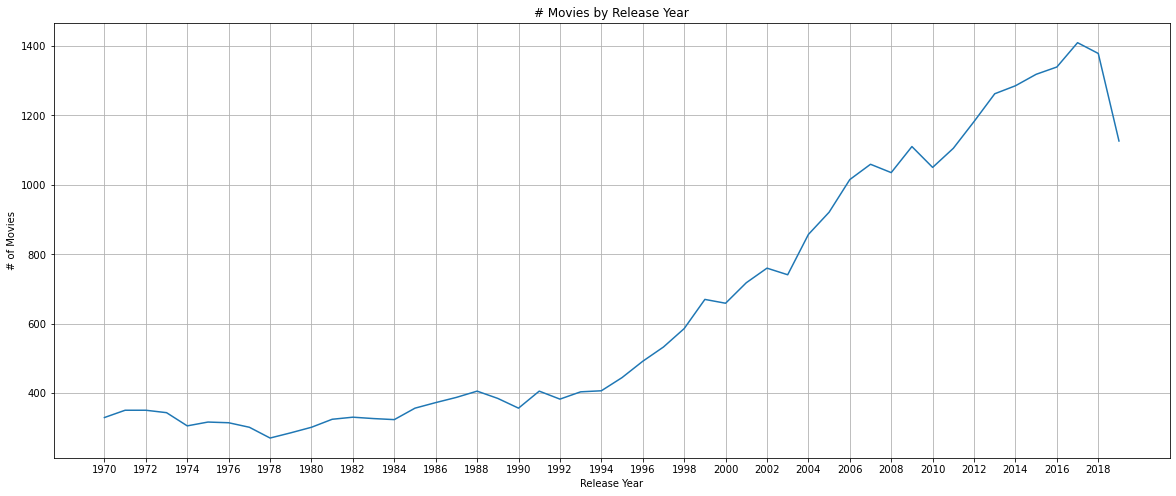

In [18]:
# Movies by release year
year_min = df_year['year'].min()
year_max = df_year['year'].max()

gb_year = df_year.groupby('year').count()['title']

# Plot
xticks = np.arange(year_min, year_max+1, 2)

_, ax = plt.subplots(figsize=(20, 8))
gb_year.plot(xticks=xticks, grid=True, ax=ax)

plt.title("# Movies by Release Year")
plt.xlabel('Release Year')
plt.ylabel('# of Movies');

In [19]:
# Movies by Decade
movies_decade = df_year.groupby('decade').agg({'title': 'count', 'duration': 'mean', 'avg_vote': 'mean'}).round(1)

movies_decade['duration'] = movies_decade['duration'].round(0).astype(int)
movies_decade.style.background_gradient().format(precision=1)

,title,duration,avg_vote
decade,,,
1970,3173,102,6.6
1980,3518,102,6.6
1990,4683,103,6.5
2000,8875,102,6.4
2010,12454,102,6.4


### Genre

In [20]:
# Set genre dataframe
cols = ['title','year','decade','genre','avg_vote']
df_genre = df[cols].copy()

In [21]:
# Genre count
df_genre['genre'] = df_genre.genre.str.split(',').apply(lambda x: [e.strip() for e in x])
genre_count = df_genre['genre'].map(Counter) # dict series
df_genre = explode(df_genre, ['genre'])

gb_genre = df_genre.groupby('genre').agg({'avg_vote':'mean', 'title':'count'}).round(2)
gb_genre.sort_values('avg_vote', ascending=False)

,avg_vote,title
genre,,
Animation,6.81,1227
Biography,6.80,1445
War,6.80,727
History,6.79,1040
Musical,6.65,349
Music,6.61,834
Drama,6.57,20657
Adventure,6.52,2901
Sport,6.46,544


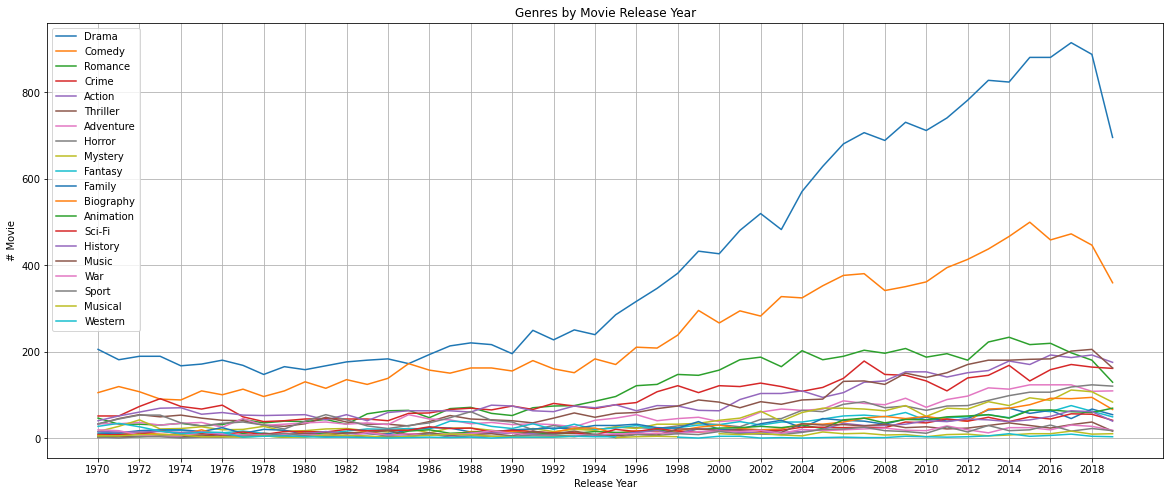

In [22]:
# Genre movies by release year
# split string and remove whitespaces
df_genre_year_counter = pd.DataFrame([genre_count, df['year']]).T
df_genre_year_counter = df_genre_year_counter.groupby('year').agg({'genre':'sum'})

genre_list = counter_display(df_genre, 'genre', 'title', None).index.values
df_genre_year_table = pd.DataFrame(index=df.sort_values('year')['year'].unique(), columns=genre_list)

for i in range(len(genre_list)):
    col = genre_list[i]
    df_genre_year_table[col] = [d.get(col) for d in df_genre_year_counter.genre]       

# Plot
xticks = np.arange(year_min, year_max+1, 2)

_, ax = plt.subplots(figsize=(20, 8))
df_genre_year_table.plot(xticks=xticks, grid=True, ax=ax)

plt.title('Genres by Movie Release Year')
plt.xlabel('Release Year')
plt.ylabel('# Movie');

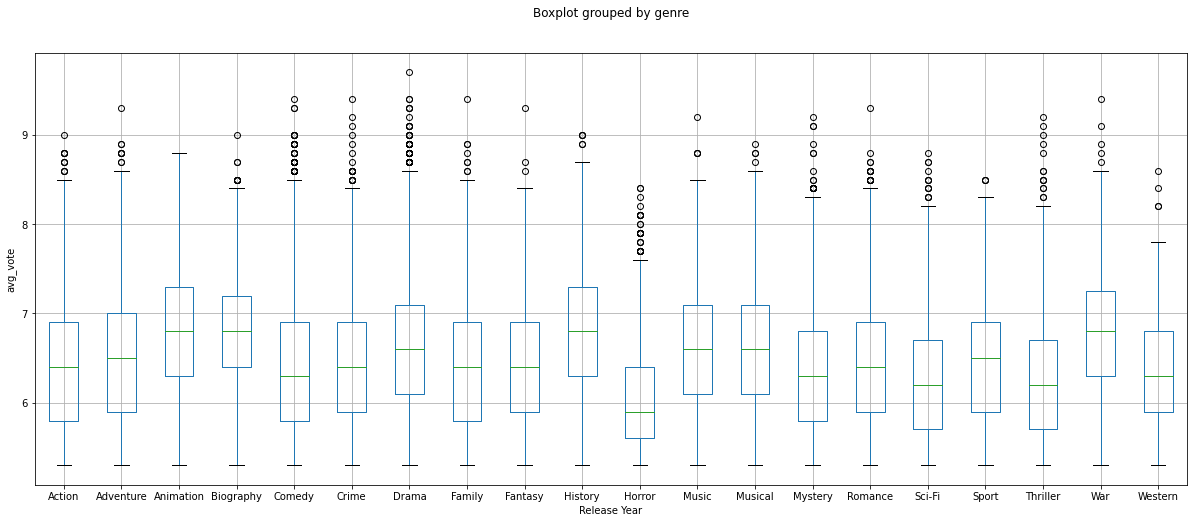

In [23]:
# Genre avg_vote
# Plot
_, ax = plt.subplots(figsize=(20, 8))
df_genre.boxplot(column='avg_vote', by='genre', ax=ax)

plt.title('')
plt.xlabel('Release Year')
plt.ylabel('avg_vote');

In [32]:
# https://sandipanweb.wordpress.com/2017/12/16/data-science-with-python-exploratory-analysis-with-movie-ratings-and-fraud-detection-with-credit-card-transactions/
gb_decade_genre = df_genre.groupby(['decade','genre']).agg({'avg_vote':'mean'}).reset_index()
gb_decade_genre = gb_decade_genre.pivot_table(values='avg_vote',index='decade',columns='genre')

gb_decade_genre.style.background_gradient().format(precision=2)

genre,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
decade,,,,,,,,,,,,,,,,,,,,
1970,6.52,6.58,7.04,6.90,6.64,6.59,6.75,6.76,6.68,6.94,6.15,6.88,6.88,6.53,6.69,6.40,6.46,6.46,7.00,6.38
1980,6.41,6.63,7.12,6.93,6.56,6.52,6.74,6.74,6.61,7.14,6.10,6.72,6.53,6.36,6.57,6.37,6.55,6.26,6.91,6.41
1990,6.35,6.46,6.84,6.88,6.45,6.47,6.65,6.33,6.43,6.89,6.06,6.71,6.65,6.49,6.49,6.25,6.43,6.30,6.93,6.40
2000,6.42,6.48,6.72,6.80,6.34,6.45,6.56,6.34,6.38,6.80,6.03,6.57,6.52,6.33,6.41,6.27,6.48,6.29,6.70,6.34
2010,6.39,6.50,6.75,6.73,6.27,6.38,6.48,6.37,6.30,6.64,5.99,6.51,6.71,6.25,6.35,6.25,6.45,6.18,6.67,6.25


# Recommender setup

In [25]:
# Set recommender dataframe
df_rec = df.copy()

In [26]:
# Content-Based Recommender
# https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_rec['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(32703, 40435)

In [27]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

#Construct a reverse map of indices and movie titles
indices = pd.Series(df_rec.index, index=df_rec['title']).drop_duplicates()

# Parse the stringified features into their corresponding python objects
features = soup_cols #['genre', 'director', 'writer', 'description']
for feature in features:
    df_rec[feature] = df_rec[feature].apply(clean_data)  
    
# Content-based Filtering
df_rec['soup'] = df_rec.apply(create_soup, axis=1)

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_rec['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

# Recommend me goodies

In [31]:
print('Recommend movies similar to:')

while True:
    movie = input() 
    print('')
    
    if movie not in list(df['title']):
        print ("'" + movie + "' isn't in the database. Try again.") 
        continue
    else:
        break

show_all(df[df['title'] == movie].iloc[:,1:-1])
print('')
print('Check these movies:')

show_all(get_recommendations(movie, indices, cosine_sim2, 30))

Recommend movies similar to:


 Dark City


,year,genre,duration,country,director,writer,actors,description,votes,avg_vote,metascore
8846,1998,"Mystery, Sci-Fi, Thriller",100,Australia,Alex Proyas,"Alex Proyas, Alex Proyas","Rufus Sewell, William Hurt, Kiefer Sutherland, Jennifer Connelly, Richard O'Brien, Ian Richardson, Bruce Spence, Colin Friels, John Bluthal, Mitchell Butel, Melissa George, Frank Gallacher, Ritchie Singer, Justin Monjo, Nicholas Bell","A man struggles with memories of his past, which includes a wife he cannot remember, and a nightmarish world, no one else seems to be waking up from.",185231,7.6,66.0



Check these movies:


,title,year,genre,duration,country,director,writer,votes,avg_vote,metascore,description,score
5893,"Spirits of the Air, Gremlins of the Clouds",1987,"Adventure, Sci-Fi",93,Australia,Alex Proyas,Alex Proyas,508,6.5,NaN,Brother and sister endure alone together in a post-apocalyptic Outback until the sudden arrival of a stranger.,0.447914
5652,The Caller,1987,"Mystery, Sci-Fi, Thriller",97,USA,Arthur Allan Seidelman,Michael Sloan,490,6.2,NaN,"One night, an unusual stranger in need asks a woman living alone in a house in the woods if he can use her phone. It soon becomes clear that they're playing a strange mind game and that there's something very wrong about the woods.",0.262613
316,The Andromeda Strain,1971,"Mystery, Sci-Fi, Thriller",131,USA,Robert Wise,"Michael Crichton, Nelson Gidding",33011,7.2,60.0,"A team of top scientists work feverishly in a secret, state-of-the-art laboratory to discover what has killed the citizens of a small town and learn how this deadly contagion can be stopped.",0.232321
21857,Z for Zachariah,2015,"Drama, Sci-Fi, Thriller",98,"Iceland, Switzerland, USA",Craig Zobel,"Nissar Modi, Robert C. O'Brien",27524,6.0,68.0,"In the wake of a disaster that wipes out most of civilization, two men and a young woman find themselves in an emotionally charged love triangle as the last known survivors.",0.223957
12553,Garage Days,2002,"Comedy, Music, Drama",105,Australia,Alex Proyas,"Alex Proyas, Dave Warner",2643,5.9,50.0,"The story of a young garage band in Sydney, Australia trying to make it big.",0.222834
16010,Isolation,2005,"Horror, Sci-Fi, Thriller",95,"UK, Ireland, USA",Billy O'Brien,Billy O'Brien,6715,5.6,NaN,"On a remote Irish farm, five people become unwilling participants in an experiment that goes nightmarishly wrong.",0.213007
32448,Excursion,2019,"Mystery, Sci-Fi, Thriller",85,UK,Martin Grof,"Magdalena Drahovska, Martin Grof",2577,6.5,NaN,"A mystery thriller about a 1980's devoted Czechoslovakian communist party member visiting his future self in London (UK), to make sure Socialism still prospers.",0.198517
13886,"I, Robot",2004,"Action, Drama, Sci-Fi",115,"USA, Germany",Alex Proyas,"Jeff Vintar, Akiva Goldsman",490975,7.1,59.0,"In 2035, a technophobic cop investigates a crime that may have been perpetrated by a robot, which leads to a larger threat to humanity.",0.197952
22037,Enter Nowhere,2011,"Mystery, Sci-Fi, Thriller",90,USA,Jack Heller,"Shawn Christensen, Jason Dolan",9063,6.5,NaN,Three strangers arrive one by one at a mysterious cabin in the middle of nowhere only to learn they've been brought together for a reason.,0.191785
22161,Condition,2011,"Drama, Mystery, Sci-Fi",70,USA,Andrei Severny,Andrei Severny,473,6.1,NaN,Two women escaping a catastrophe look for salvation in sound and nature.,0.167968
